In [1]:
from ngraph.scenario import Scenario
from ngraph.traffic_demand import TrafficDemand
from ngraph.traffic_manager import TrafficManager
from ngraph.lib.flow_policy import FlowPolicyConfig, FlowPolicy, FlowPlacement
from ngraph.lib.algorithms.base import PathAlg, EdgeSelect
from ngraph.failure_manager import FailureManager
from ngraph.failure_policy import FailurePolicy, FailureRule, FailureCondition

In [2]:
scenario_yaml = """
blueprints:
  brick_2tier:
    groups:
      t1:
        node_count: 8
        name_template: t1-{node_num}
      t2:
        node_count: 8
        name_template: t2-{node_num}

    adjacency:
      - source: /t1
        target: /t2
        pattern: mesh
        link_params:
          capacity: 2
          cost: 1

  3tier_clos:
    groups:
      b1:
        use_blueprint: brick_2tier
      b2:
        use_blueprint: brick_2tier
      spine:
        node_count: 64
        name_template: t3-{node_num}

    adjacency:
      - source: b1/t2
        target: spine
        pattern: one_to_one
        link_params:
          capacity: 2
          cost: 1
      - source: b2/t2
        target: spine
        pattern: one_to_one
        link_params:
          capacity: 2
          cost: 1

network:
  name: "3tier_clos_network"
  version: 1.0

  groups:
    my_clos1:
      use_blueprint: 3tier_clos

    my_clos2:
      use_blueprint: 3tier_clos

  adjacency:
    - source: my_clos1/spine
      target: my_clos2/spine
      pattern: one_to_one
      link_params:
        capacity: 1
        cost: 1
    - source: my_clos1/spine
      target: my_clos2/spine
      pattern: one_to_one
      link_params:
        capacity: 1
        cost: 1
    - source: my_clos1/spine
      target: my_clos2/spine
      pattern: one_to_one
      link_params:
        capacity: 1
        cost: 1
    - source: my_clos1/spine
      target: my_clos2/spine
      pattern: one_to_one
      link_params:
        capacity: 1
        cost: 1
"""
scenario = Scenario.from_yaml(scenario_yaml)
network = scenario.network

In [3]:
network.max_flow(
    source_path=r"my_clos1.*(b[0-9]*)/t1",
    sink_path=r"my_clos2.*(b[0-9]*)/t1",
    mode="combine",
    shortest_path=True,
)

{('b1|b2', 'b1|b2'): 256.0}

In [4]:
d = TrafficDemand(
    source_path=r"my_clos1.*(b[0-9]*)/t1",
    sink_path=r"my_clos2.*(b[0-9])/t1",
    demand=256,
    mode="full_mesh",
    flow_policy_config=FlowPolicyConfig.SHORTEST_PATHS_ECMP,
)
demands = [d]
tm = TrafficManager(
    network=network,
    traffic_demands=demands,
)
tm.build_graph()
tm.expand_demands()
tm.place_all_demands(placement_rounds=50)

256.0

In [5]:
my_rules = [
    FailureRule(
        conditions=[FailureCondition(attr="type", operator="==", value="link")],
        logic="and",
        rule_type="choice",
        count=2,
    ),
]
fpolicy = FailurePolicy(rules=my_rules)

# Run Monte Carlo
fmgr = FailureManager(network, demands, failure_policy=fpolicy)
results = fmgr.run_monte_carlo_failures(iterations=30, parallelism=10)
overall = results["overall_stats"]
print("Overall Statistics:")
for k, v in overall.items():
    print(f"  {k}: {v:.2f}")

Overall Statistics:
  mean: 209.26
  stdev: 23.16
  min: 190.04
  max: 251.57


/var/folders/xh/83kdwyfd0fv66b04mchbfzcc0000gn/T/ipykernel_50158/4192461833.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Priority")


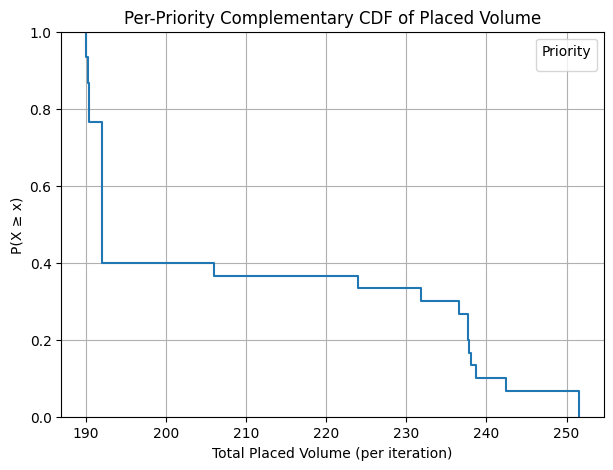

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict


def plot_priority_cdf(results, complementary: bool = True):
    """
    Plots an empirical (complementary) CDF of placed volume for each priority.

    Args:
        results: The dictionary returned by run_monte_carlo_failures, containing:
            {
                "overall_stats": {...},
                "by_src_dst": {
                    (src, dst, priority): [
                        {"iteration": int, "total_volume": float, "placed_volume": float, ...},
                        ...
                    ],
                    ...
                }
            }
        complementary: If True, plots a complementary CDF (P(X >= x)).
                       If False, plots a standard CDF (P(X <= x)).
    """
    by_src_dst = results["by_src_dst"]  # {(src, dst, priority): [...]}

    # 1) Aggregate total placed volume for each iteration & priority
    #    (similar logic as before, but we'll directly store iteration-level sums).
    volume_per_iter_priority = defaultdict(float)
    for (src, dst, priority), data_list in by_src_dst.items():
        for entry in data_list:
            it = entry["iteration"]
            volume_per_iter_priority[(it, priority)] += entry["placed_volume"]

    # 2) Convert to a tidy DataFrame with columns: [iteration, priority, placed_volume]
    rows = []
    for (it, prio), vol_sum in volume_per_iter_priority.items():
        rows.append({"iteration": it, "priority": prio, "placed_volume": vol_sum})

    plot_df = pd.DataFrame(rows)

    # 3) Use seaborn's ECDF plot (which can do either standard or complementary CDF)
    plt.figure(figsize=(7, 5))
    sns.ecdfplot(
        data=plot_df,
        x="placed_volume",
        hue="priority",
        complementary=complementary,  # True -> CCDF, False -> normal CDF
    )
    if complementary:
        plt.ylabel("P(X ≥ x)")
        plt.title("Per-Priority Complementary CDF of Placed Volume")
    else:
        plt.ylabel("P(X ≤ x)")
        plt.title("Per-Priority CDF of Placed Volume")

    plt.xlabel("Total Placed Volume (per iteration)")
    plt.grid(True)
    plt.legend(title="Priority")
    plt.show()


plot_priority_cdf(results, complementary=True)